# US Flight Performance 
## RITA Flight Data Exploration

## Analysis Overview
The purpose of this investigation is to dive deep into flight performance dataset to analyze arrival and departure delays and investigate the reasons behind flight delays in January, 2019 in the US.

## Dataset Overview
This dataset contains a list of 583,985 flights that departed and arrived in the month of January, 2019 with many variables of interest like - departure time, arrival time, flight operator, delay reasons/times (NAS, security, carrier, etc.) and many more.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [37]:
flight_info = pd.read_csv('flights.csv')
flight_info.columns = map(str.lower, flight_info.columns)
flight_info.drop(columns=['unnamed: 35'],inplace=True)
#since all records are from January of 2019, dropping year, qtr and months columns
flight_info.drop(columns=['year', 'quarter', 'month'], inplace=True)

## 1. What was the average departure and arrival delays for busiest airports in the dataset?

In [38]:
#subset busiest airports from flight_info dataframe
busiest_origin_airports = set(flight_info.origin.value_counts().index[:25])
busiest_destination_airports = set(flight_info.dest.value_counts().index[:25])
busiest_airports = busiest_origin_airports.intersection(busiest_destination_airports)

<Figure size 1080x576 with 0 Axes>

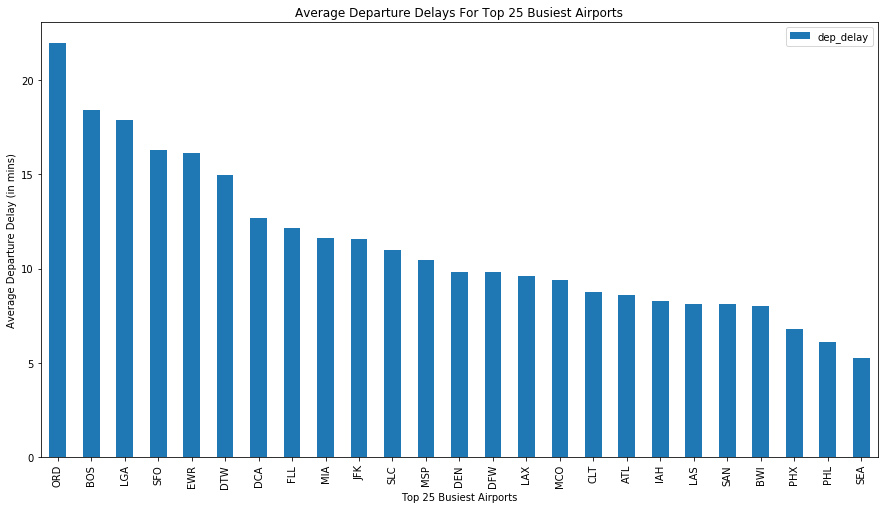

In [39]:
df = flight_info[flight_info.origin.isin(busiest_airports)]
df = df[df.dest.isin(busiest_airports)]
plt.figure(figsize=(15,8))
df.groupby('origin').agg({'dep_delay':'mean'}).sort_values('dep_delay', ascending=False).plot.bar(figsize=(15,8))
plt.ylabel('Average Departure Delay (in mins)')
plt.xlabel('Top 25 Busiest Airports')
plt.title('Average Departure Delays For Top 25 Busiest Airports');

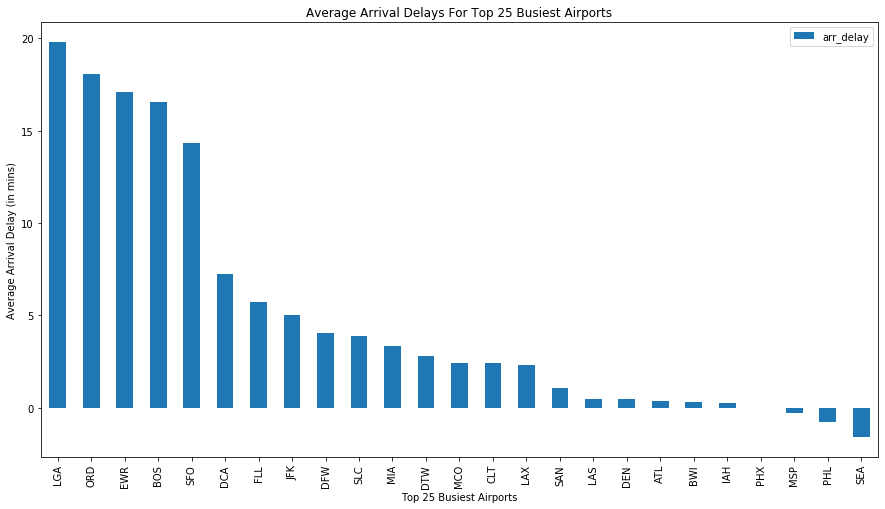

In [40]:
df.groupby('dest').agg({'arr_delay':'mean'}).sort_values('arr_delay', ascending=False).plot.bar(figsize=(15,8))
plt.ylabel('Average Arrival Delay (in mins)')
plt.xlabel('Top 25 Busiest Airports')
plt.title('Average Arrival Delays For Top 25 Busiest Airports');

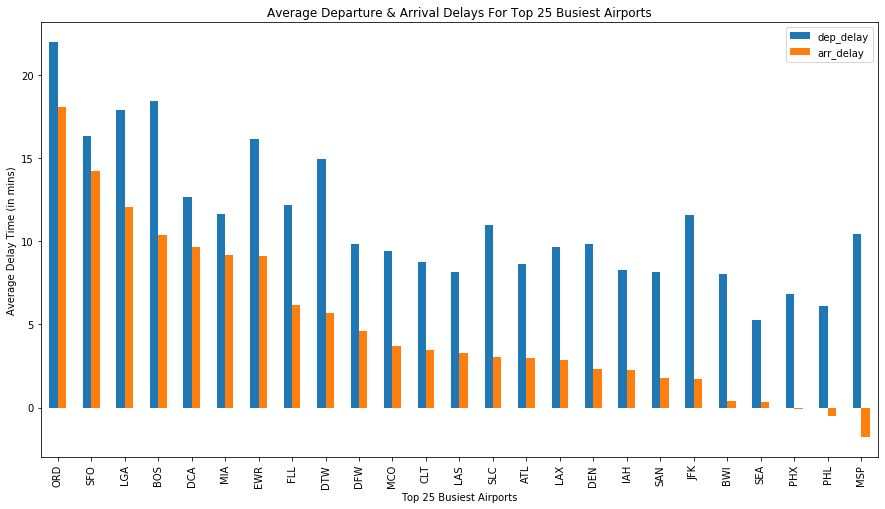

In [41]:
df.groupby(['origin']).agg({'dep_delay':'mean', 'arr_delay':'mean'}).sort_values('arr_delay', ascending=False).plot.bar(figsize=(15,8))
plt.ylabel('Average Delay Time (in mins)')
plt.xlabel('Top 25 Busiest Airports')
plt.title('Average Departure & Arrival Delays For Top 25 Busiest Airports');

### Analysis
Chicago had the highest average departure and arrival delay time.

Even though Phoenix, Philadelphia, and Minneapolis had high average departure delays, they rarely had any average arrival delays.  

## 2. What was the best time for the passengers to catch a flight?

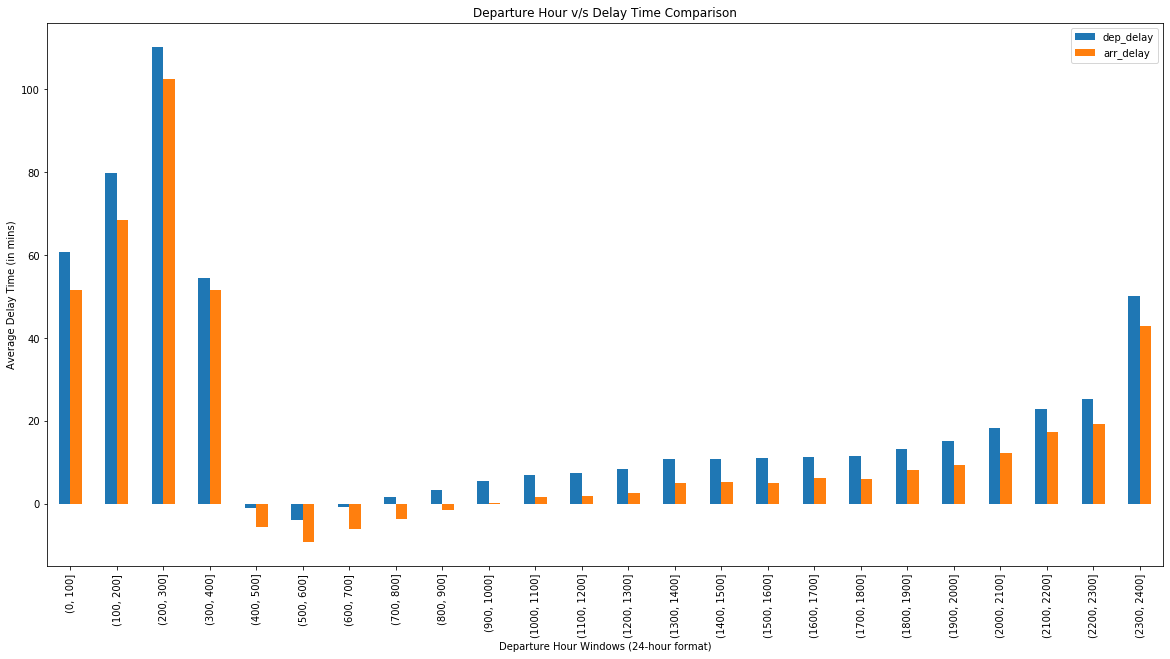

In [42]:
#extract departure hour value from departure time field and create windows
flight_info['dep_hour']=pd.cut(flight_info.dep_time, list(range(0, 2500, 100)))
flight_info.drop(index=flight_info[flight_info.dep_hour.isna()==True].index, inplace=True)
flight_info.groupby('dep_hour').agg({'dep_delay':'mean', 'arr_delay':'mean'}).plot.bar(figsize=(20,10))
plt.xlabel('Departure Hour Windows (24-hour format)')
plt.ylabel('Average Delay Time (in mins)')
plt.title('Departure Hour v/s Delay Time Comparison')
plt.show()

### Analysis
Best time to travel (without any delays) was between 4AM and 9AM. After that, departure and arrival delays increased as the day passed by.

## 3. Which carriers had the maximum delayed flights?
Assumption - Considering that a flight is delayed when the arrival time is greater than the scheduled arrival time.

In [43]:
delayed_indicator = []
for index, row in flight_info.iterrows():
    if (row.arr_delay > 0):
        delayed_indicator.append(True)
    else:
        delayed_indicator.append(False)
flight_info['delayed_indicator'] = delayed_indicator

flights_delayed = flight_info[flight_info.delayed_indicator==True]

#delete all nan records from delayed flights dataset
flights_delayed.dropna(inplace=True, how='any', subset=['carrier_delay', 'security_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay'])
flights_delayed.reset_index(inplace=True)
flights_delayed.drop(columns=['index'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


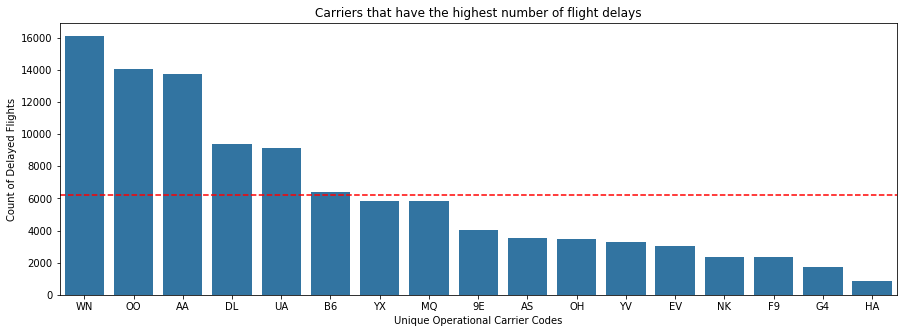

In [44]:
order = flights_delayed.op_unique_carrier.value_counts().index
plt.figure(figsize=(15,5))
sb.countplot(data = flights_delayed, x='op_unique_carrier', order = order, color = sb.color_palette()[0])
plt.xlabel('Unique Operational Carrier Codes') 
plt.ylabel('Count of Delayed Flights')
plt.title('Carriers that have the highest number of flight delays')
average_val = round(flights_delayed.count()[0]/flights_delayed.op_unique_carrier.nunique())
plt.axhline(average_val, ls = '--', color="r");

### Analysis
Flight operators listed below had the maximum flights delayed in January, 2019. <br>
WN - Southwest Airlines<br>
OO - SkyWest Airlines<br>
AA - American Airlines<br>
DL - Delta Airlines<br>
UA - United Airlines<br>

## 4. Of all delayed flights for the above mentioned operators, what was the most reported reason for the delay?

In [45]:
#getting data only for flight carriers that have higher than average delays
carriers_above_average_delay = list(flights_delayed.groupby('op_unique_carrier').op_unique_carrier.count()[flights_delayed.groupby('op_unique_carrier').op_unique_carrier.count() > average_val].index)
flights_delayed_subset = flight_info[flight_info['op_unique_carrier'].isin(carriers_above_average_delay)]
flights_delayed_subset.reset_index(inplace=True)
flights_delayed_subset.drop(columns=['index'], inplace=True)

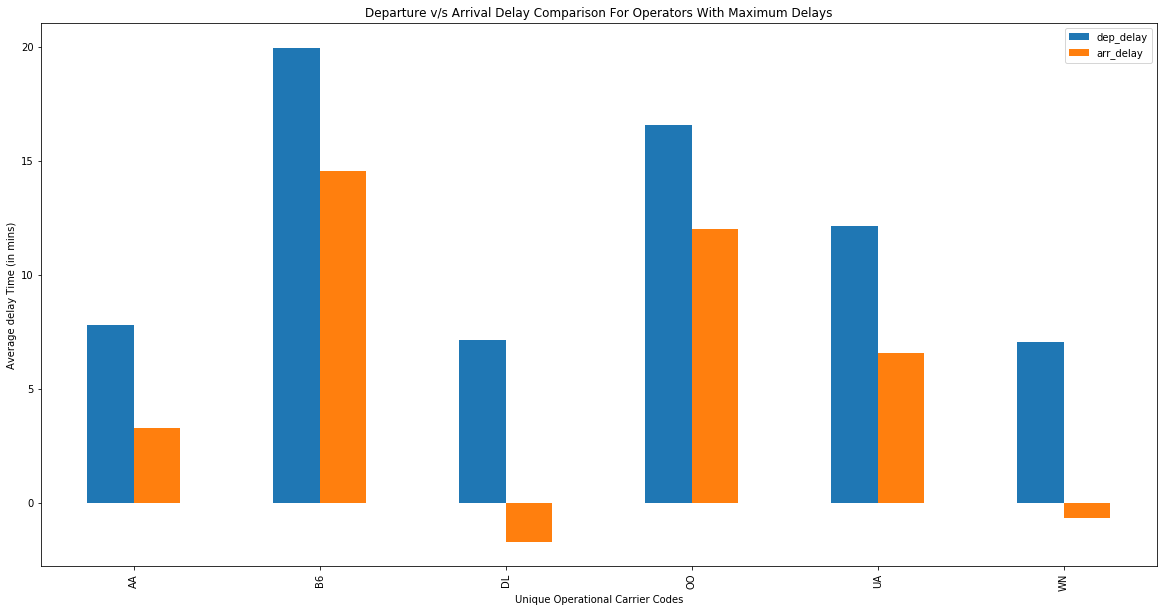

In [46]:
flights_delayed_subset.groupby('op_unique_carrier').agg({'dep_delay':'mean', 'arr_delay':'mean'}).sort_values('op_unique_carrier').plot.bar(figsize=(20,10))
plt.xlabel('Unique Operational Carrier Codes')
plt.ylabel('Average delay Time (in mins)')
plt.title('Departure v/s Arrival Delay Comparison For Operators With Maximum Delays');

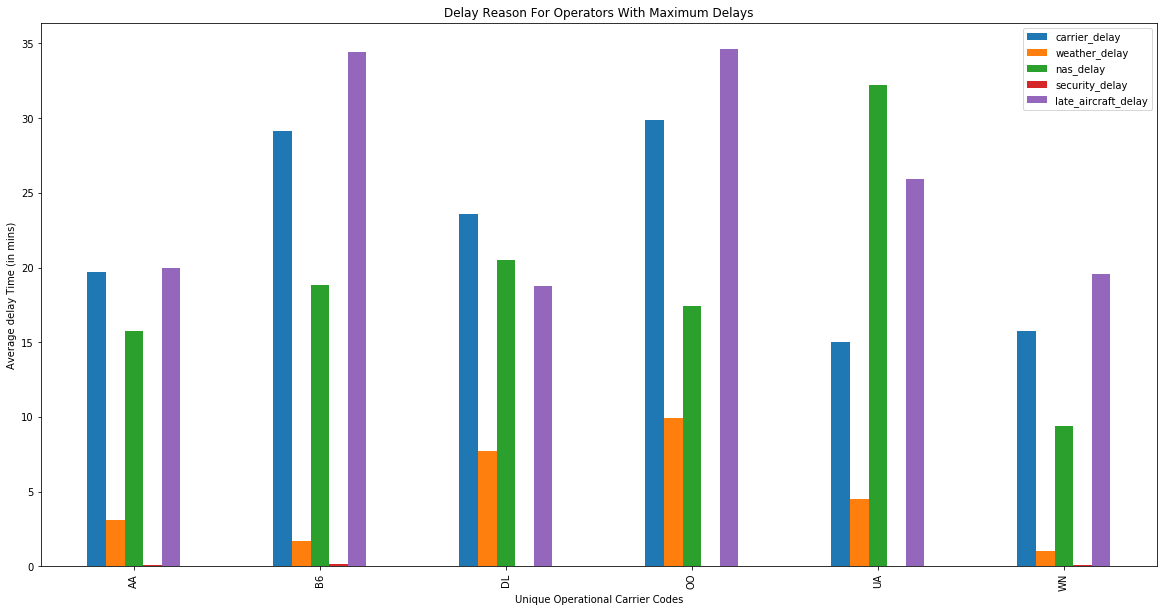

In [47]:
flights_delayed_subset.groupby('op_unique_carrier').agg({'carrier_delay':'mean', 'weather_delay':'mean' , 'nas_delay':'mean', 'security_delay':'mean', 'late_aircraft_delay':'mean'}).sort_values('op_unique_carrier').plot.bar(figsize=(20,10))
plt.xlabel('Unique Operational Carrier Codes')
plt.ylabel('Average delay Time (in mins)')
plt.title('Delay Reason For Operators With Maximum Delays');

### Analysis
For all these operators, B6 (or JetBlue) has the highest average time of departure and arrival delays, which can be attributed to aircraft arriving late and/or carrier operations.<br> 

That said, although DL (or Delta) and WN (or Southwest) have high average delay times, they rarely have any average arrival delays.<br> 

UA (or United Airlines) is the most affected by National Air System performance which is the major reason for its flight delays.<br>

## 5. Which day of the week observed the highest average delays?

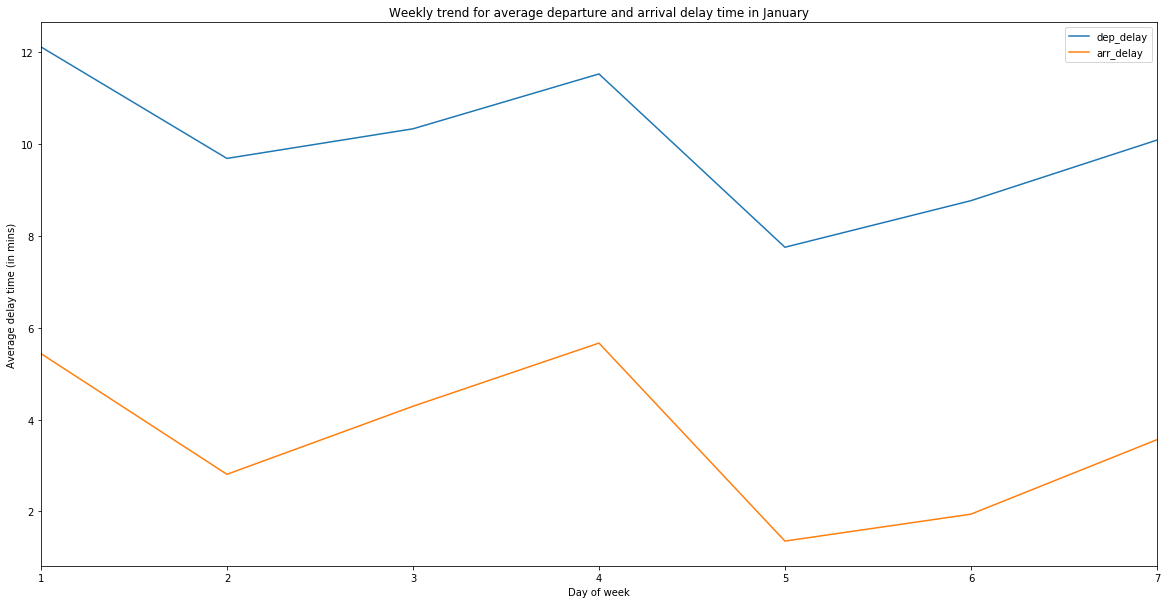

In [48]:
flights_delayed_subset.groupby('day_of_week').agg({'dep_delay':'mean', 'arr_delay':'mean'}).sort_values('day_of_week').plot.line(figsize=(20,10))
plt.xlabel('Day of week')
plt.ylabel('Average delay time (in mins)')
plt.title('Weekly trend for average departure and arrival delay time in January');

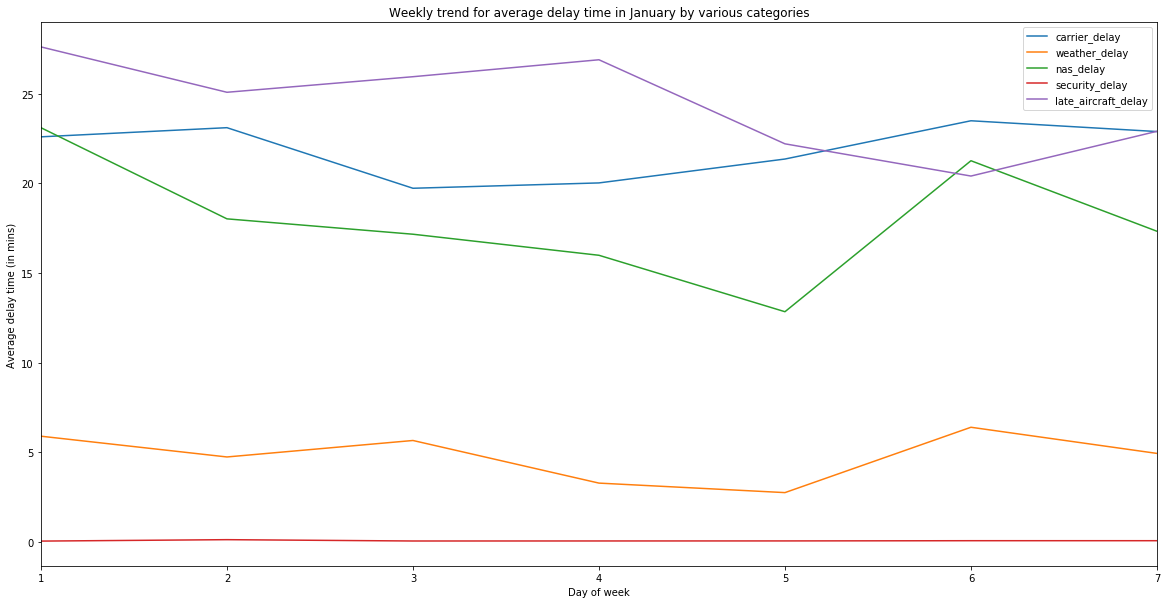

In [49]:
flights_delayed_subset.groupby('day_of_week').agg({'carrier_delay':'mean', 'weather_delay':'mean' , 'nas_delay':'mean', 'security_delay':'mean', 'late_aircraft_delay':'mean'}).sort_values('day_of_week').plot.line(figsize=(20,10))
plt.xlabel('Day of week')
plt.ylabel('Average delay time (in mins)')
plt.title('Weekly trend for average delay time in January by various categories');

### Analysis
The first day of the week (Monday) has the highest average departure and arrival delays, majority of which can reasoned in terms of higher average late aircraft delays and delays caused by National Air System. 

## Summary 
1. Chicago had the highest average departure and arrival delay time. <br>
2. Phoenix, Philadelphia, and Minneapolis had the least average arrival delays.<br>
3. No flight delays were observed between 4AM and 9AM.<br>
4. Flight operators that had highest number of delays are:: WN - Southwest Airlines, OO - SkyWest Airlines, AA - American Airlines, DL - Delta Airlines, UA - United Airlines<br>
5. B6 (or JetBlue) had the highest average departure and arrival delays because of late aircraft and/or carrier operations. DL (or Delta) and WN (or Southwest) have high average delays but low average arrival delays. UA (or United Airlines) is the most affected by National Air System performance which is the major reason for its flight delays.<br>
6. The first day of the week (Monday) has the highest average departure and arrival delays, majority of which can reasoned in terms of higher average late aircraft delays and delays caused by National Air System.